In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import cv2

In [2]:
np.random.seed(0)

In [3]:
df_orig = pd.read_csv('../wf_df_raw.csv')

In [4]:
df = df_orig.copy()

In [5]:
df = df.dropna(subset=['img_name'])

In [74]:
df['brand'] = df['brand'].map(lambda x: x.replace(' ', '_'))

In [75]:
brand_list = list(df['brand'].value_counts()[:5].index)

In [76]:
brand_list.sort()

In [8]:
BASE_DIR = os.path.dirname(os.getcwd())

RAW_IMGS_DIR = os.path.join(BASE_DIR, 'raw_images')

IMAGES_DIR = os.path.join(BASE_DIR, 'Images')
TRAINING_DIR = os.path.join(IMAGES_DIR, 'Training')
VALIDATION_DIR = os.path.join(IMAGES_DIR, 'Validation')

In [9]:
try:
    shutil.rmtree(IMAGES_DIR)
except: pass

os.mkdir(IMAGES_DIR)
os.mkdir(TRAINING_DIR)
os.mkdir(VALIDATION_DIR)

In [10]:
for brand in brand_list:
    os.mkdir(os.path.join(TRAINING_DIR, brand))
    os.mkdir(os.path.join(VALIDATION_DIR, brand))

In [11]:
for index, row in df.iterrows():
    
    CURR_IMG_DIR = os.path.join(RAW_IMGS_DIR, row['img_name'])
    
    random_number = np.random.randint(1,101)
    
    if row['brand'] in brand_list and random_number <= 80:
        shutil.copy(CURR_IMG_DIR, os.path.join(TRAINING_DIR, row['brand']))
        
    elif row['brand'] in brand_list and random_number > 80:
        shutil.copy(CURR_IMG_DIR, os.path.join(VALIDATION_DIR, row['brand']))

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

Found 1964 images belonging to 5 classes.


In [13]:
validation_datagen = ImageDataGenerator(rescale=1/255)

validation_generator = train_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

Found 489 images belonging to 5 classes.


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])

In [16]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
62/62 [==============================] - 66s 1s/step - loss: 1.6423 - accuracy: 0.2918 - val_loss: 1.2724 - val_accuracy: 0.4990
Epoch 2/5
62/62 [==============================] - 56s 906ms/step - loss: 1.1565 - accuracy: 0.5621 - val_loss: 0.8851 - val_accuracy: 0.6605
Epoch 3/5
62/62 [==============================] - 54s 874ms/step - loss: 0.7673 - accuracy: 0.7135 - val_loss: 0.5546 - val_accuracy: 0.7996
Epoch 4/5
62/62 [==============================] - 54s 875ms/step - loss: 0.4780 - accuracy: 0.8223 - val_loss: 0.6369 - val_accuracy: 0.7812
Epoch 5/5
62/62 [==============================] - 54s 874ms/step - loss: 0.3460 - accuracy: 0.8808 - val_loss: 0.5057 - val_accuracy: 0.8282


In [25]:
pre_trained_model = tf.keras.applications.InceptionV3(
    include_top = False,
    weights = "imagenet",
    input_shape = (300, 300, 3)
)

87916544/87910968 [==============================] - 12s 0us/step


In [26]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [27]:
last_layer = pre_trained_model.layers[-1]
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 2048)


In [28]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(5, activation='softmax')(x)

In [29]:
model = tf.keras.models.Model(pre_trained_model.input, x)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size=32,
    epochs=15
)

Epoch 1/15
62/62 [==============================] - 62s 927ms/step - loss: 13.8038 - accuracy: 0.4165 - val_loss: 1.2090 - val_accuracy: 0.6994
Epoch 2/15
62/62 [==============================] - 55s 892ms/step - loss: 1.5151 - accuracy: 0.7524 - val_loss: 0.7442 - val_accuracy: 0.8609
Epoch 3/15
62/62 [==============================] - 56s 911ms/step - loss: 0.6634 - accuracy: 0.8600 - val_loss: 0.2518 - val_accuracy: 0.9387
Epoch 4/15
62/62 [==============================] - 56s 909ms/step - loss: 0.6676 - accuracy: 0.8867 - val_loss: 3.5253 - val_accuracy: 0.6401
Epoch 5/15
62/62 [==============================] - 56s 902ms/step - loss: 0.4163 - accuracy: 0.9424 - val_loss: 0.2638 - val_accuracy: 0.9530
Epoch 6/15
62/62 [==============================] - 56s 899ms/step - loss: 0.2844 - accuracy: 0.9621 - val_loss: 0.3277 - val_accuracy: 0.9387
Epoch 7/15
62/62 [==============================] - 57s 917ms/step - loss: 0.2427 - accuracy: 0.9649 - val_loss: 0.2847 - val_accuracy: 0.955

In [163]:
model.evaluate(validation_generator)

16/16 [==============================] - 11s 664ms/step - loss: 0.3567 - accuracy: 0.9550


[0.35669082403182983, 0.9550102353096008]

In [220]:
BRAND = random.choice(brand_list)
BRAND_DIR = os.path.join(VALIDATION_DIR, BRAND)
WATCHES = os.listdir(BRAND_DIR)
WATCH = random.choice(WATCHES)
WATCH_DIR = os.path.join(BRAND_DIR, WATCH)

In [221]:
img = image.load_img(WATCH_DIR, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

prediction = model.predict(x)

Actual:		Omega
Predicted:	Breitling


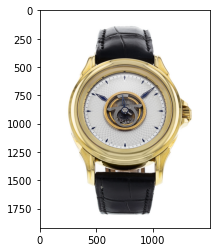

In [222]:
img_orig = cv2.imread(WATCH_DIR)[...,::-1]
imgplot = plt.imshow(img_orig)
print(f"Actual:\t\t{BRAND}\nPredicted:\t{brand_list[np.argmax(prediction[0])]}")

In [218]:
correct = 0
n = 200

for i in range(n):
    BRAND = random.choice(brand_list)
    BRAND_DIR = os.path.join(VALIDATION_DIR, BRAND)
    WATCHES = os.listdir(BRAND_DIR)
    WATCH = random.choice(WATCHES)
    WATCH_DIR = os.path.join(BRAND_DIR, WATCH)
    
    img = image.load_img(WATCH_DIR, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    prediction = model.predict(x)
    
    if BRAND == brand_list[np.argmax(prediction[0])]:
        correct += 1

print(round(100 * correct/n, 2))

0.19
